# U-Net Segmentation with Pretrained Weights

## Prepare Environment

In [1]:
import segmentation_models as sm
import keras
import tensorflow as tf
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

C:\Users\welcm\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\welcm\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\welcm\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\welcm\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\welcm\AppData\Roaming\Python\Python38\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Segmentation Models: using `keras` framework.


In [2]:
SIZE_X = 256
SIZE_Y = 256
n_classes = 3

# Load Images/Masks

In [3]:
DIR = "C:/Users/welcm/Documents/a-coral-project/coral_data/data/" 

image_names = glob.glob(DIR + 'images_aug_c1p3_b1p1/*.jpg')
image_names.sort()
image_names_subset = image_names
images = [cv2.imread(image, 1) for image in image_names_subset] #SM backbones use 3 channel images, so let us read images in color.
image_dataset = np.array(images)

mask_names = glob.glob(DIR + 'masks/*.png')
mask_names.sort()
mask_names_subset = mask_names
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)

In [4]:
print("Total images in the original dataset are: ", len(image_names))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  4856
Image data shape is:  (4856, 256, 256, 3)
Mask data shape is:  (4856, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2]


In [5]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

C:\Users\welcm\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2], dtype=int64)

In [6]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)

# Data Augmentation

### Sharpening

In [7]:
from PIL import Image, ImageEnhance
from numpy import asarray

aug_images = [] 

for i in range(len(images)):
    image = images[i]
    data = Image.fromarray(image)
    
    enhancer = ImageEnhance.Sharpness(data)
    factor = 2
    new_image = enhancer.enhance(factor)   
    
    aug_images.append(new_image)

In [8]:
from numpy import asarray

arr_aug_images = []

for i in range(len(aug_images)):
    img = asarray(aug_images[i])
    arr_aug_images.append(img)

# Overview of Data

In [9]:
image_dataset = np.array(arr_aug_images)
mask_dataset = np.array(masks)

In [10]:
print(len(image_dataset))
print(len(mask_dataset))

4856
4856


# Data Processing

In [11]:
#Normalize images
image_dataset = image_dataset /255.

In [12]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.15, random_state = 42)

In [13]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [14]:
print(y_train.shape)
print(y_test.shape)

(4127, 256, 256, 1)
(729, 256, 256, 1)


# Begin Model Code

In [15]:
#Reused parameters in all models
import tensorflow
n_classes=3
activation='softmax'

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
###Model 
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)

In [17]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [32]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=3, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [34]:
DIR = "C:/Users/welcm/Documents/a-coral-project/coral_data/" 

history=model.fit(X_train_processed, 
          y_train_cat,
          batch_size=8, 
          epochs=25,
          verbose=1,
          validation_data=(X_test_processed, y_test_cat))


model.save(DIR + 'res34_backbone_codeD.hdf5')

Epoch 1/25
516/516 [==============================] - 1495s 3s/step - loss: 0.5133 - iou_score: 0.5192 - f1-score: 0.6311 - val_loss: 0.7124 - val_iou_score: 0.3041 - val_f1-score: 0.3212
Epoch 2/25
516/516 [==============================] - 1393s 3s/step - loss: 0.2451 - iou_score: 0.6966 - f1-score: 0.7990 - val_loss: 0.5038 - val_iou_score: 0.4578 - val_f1-score: 0.5505
Epoch 3/25
516/516 [==============================] - 1381s 3s/step - loss: 0.2180 - iou_score: 0.7131 - f1-score: 0.8121 - val_loss: 0.2093 - val_iou_score: 0.7234 - val_f1-score: 0.8196
Epoch 4/25
516/516 [==============================] - 1491s 3s/step - loss: 0.1988 - iou_score: 0.7326 - f1-score: 0.8268 - val_loss: 0.2455 - val_iou_score: 0.6805 - val_f1-score: 0.7830
Epoch 5/25
516/516 [==============================] - 1530s 3s/step - loss: 0.1974 - iou_score: 0.7332 - f1-score: 0.8272 - val_loss: 0.2054 - val_iou_score: 0.7263 - val_f1-score: 0.8198
Epoch 6/25
516/516 [==============================] - 1384s 

C:\Users\welcm\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


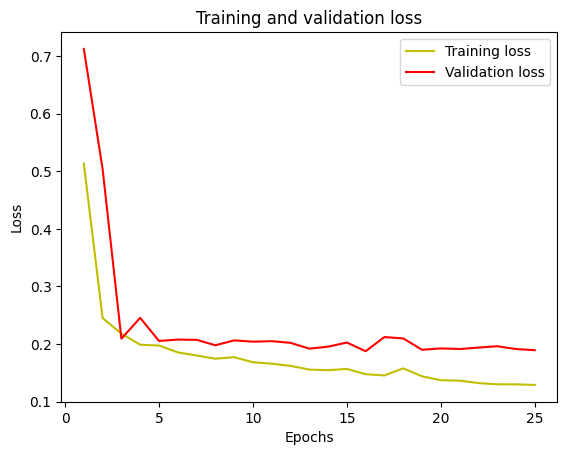

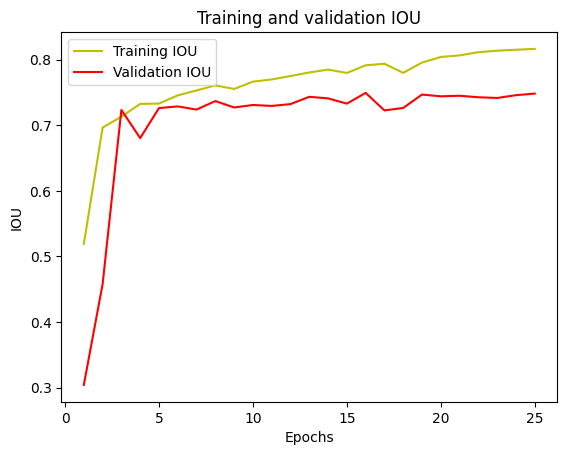

In [35]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [24]:
from keras.models import load_model
DIR = "C:/Users/welcm/Documents/a-coral-project/coral_data/" 
### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model = load_model(DIR + 'res34_backbone_codeD.hdf5', compile=False)

In [25]:
#IOU
from keras.metrics import MeanIoU
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [ ]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Filtering blank estimates

In [78]:
#IOU
from keras.metrics import MeanIoU
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [79]:
y_test_list = y_test.tolist()
y_pred_maxarg_list = y_pred_argmax.tolist()

new_y_test = y_test.tolist()
new_y_pred_maxarg = y_pred_argmax.tolist()

for i in range (len(y_test_list)):
    actual_mask = y_test[i]
    predicted_mask = y_pred_argmax[i]

    actual_mask_values = np.unique(actual_mask)
    predict_mask_values = np.unique(predicted_mask)
    
    if(len(predict_mask_values) == 1):
        new_y_test.remove(y_test_list[i])
        new_y_pred_maxarg.remove(y_pred_maxarg_list[i])

In [80]:
process_y_test = np.expand_dims(new_y_test, axis=3)
final_y_test = process_y_test.squeeze(4)

process_y_pred_maxarg = np.expand_dims(new_y_pred_maxarg, axis=3)
final_y_pred_maxarg = process_y_pred_maxarg.squeeze()

In [86]:
#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(final_y_test[:,:,:,0], final_y_pred_maxarg)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.76582646


In [87]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class1_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class0_IoU)
print("IoU for class2 is: ", class1_IoU)
print("IoU for class3 is: ", class2_IoU)


[[1.6777216e+07 5.5270400e+05 2.0372700e+05]
 [5.8503700e+05 1.8568140e+06 4.1600000e+02]
 [3.5570800e+05 7.1670000e+03 1.9074070e+06]]
IoU for class1 is:  0.90813357
IoU for class2 is:  0.6184972
IoU for class3 is:  0.7708486


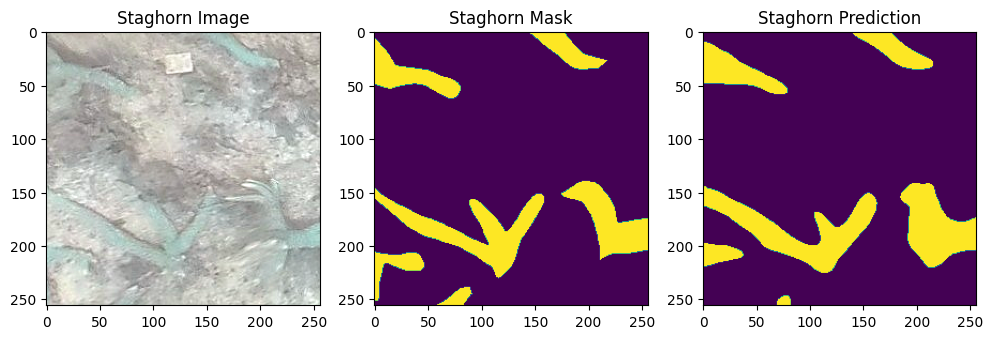

In [63]:
import random
img_number = random.randint(0, len(X_test_processed)-1)
img = X_test_processed[img_number]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]

unique = np.unique(mask)
if 1 in unique:
    name = "Staghorn"
else:
    name = "Elkhorn"

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title(name + ' Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title(name + ' Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title(name + ' Prediction')
plt.imshow(prediction)
plt.show()

## Classification

In [94]:
correct = 0
incorrect = 0
num_single = 0
single = False
single_correct = 0
single_incorrect = 0

for i in range (len(y_test)):
    
    single = False
    
    mask = y_test[i]
    prediction = y_pred_argmax[i]

    mask_unique = np.unique(mask)
    prediction_unique = np.unique(prediction)
    
    classification = mask_unique[1]
    
    if(len(prediction_unique) == 1):
        num_single += 1
        single = True
    
    if classification in prediction_unique:
        correct += 1
        if single == True:
            single_correct += 1
            
    else:
        incorrect += 1
        if single == True:
            single_incorrect += 1
 

print("-----With Zero Mask Predictions-----")
print("correct: " + str(correct))
print("incorrect: " + str(incorrect))
print("total: " + str(correct+incorrect))
total = correct+incorrect
print("accuracy: " + str(correct/total))

print("-----Without Zero Mask Predictions-----")
print("num single: " + str(num_single))
print("single_correct: " + str(single_correct))
print("single_incorrect: " + str(single_incorrect))
print("accuracy: " + str(correct/(total-num_single)))


-----With Zero Mask Predictions-----
correct: 657
incorrect: 72
total: 729
accuracy: 0.9012345679012346
-----Without Zero Mask Predictions-----
num single: 70
single_correct: 0
single_incorrect: 70
accuracy: 0.9969650986342944
